[View in Colaboratory](https://colab.research.google.com/github/surajx/Fashion-MNIST-Sonnet/blob/master/Fashion_MNIST_feat_Deepmind_Sonnet.ipynb)

# Fashion MNIST Classification with TensorFlow feat. Deepmind Sonnet

In this notebook we'll be looking at how to do a simple classification task using TesorFlow (TF). My aim here is two pronged: 
1. Show how to use the bells and whistles provided by TF in a simple Machine Learning (ML) task.
2. Act as a simple getting started example for Deepmind's [Sonnet](https://deepmind.github.io/sonnet/) library.

Much of the explanations is in the form of comments within the code, so please consider reading the code along with the post. The post is writtern with the assumtion that the reader has a basic understanding of ML and the TF framework. That said, I have tried to provide extenal links to the technical terms I have used.

To kick things off we'll first install sonnet into the colab VM and then import the required python libraries. If you're new to colab follow this [guide](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) to familiarize yourself with the interface.

In [0]:
# Install sonnet (it doesn't come preinstalled in the colab VM).
! pip install -q dm-sonnet

In [0]:
# Import necessary libraries
import numpy as np
import sonnet as snt
import tensorflow as tf
import matplotlib.pyplot as plt

import time  # To time each epoch

# Needed to download Fashion-MNIST (FMNIST) dataset without much hassle.
from tensorflow.keras import datasets

In [29]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.9.0


## Download the Dataset

The more traditional MNIST dataset has been overused to a point (99%+ accuracy) where its no longer a worthy classification problem. [Zalando Research](https://research.zalando.com/) came up with a new starting point for Machine Learning research, where rather than the 10 digits, 10 different clothing apparels are captured in 28x28 images. Myriard variations of these 10 apparels constitute the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

<table>
  <tr><td>
    <img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="560">
  </td></tr>
  <tr><td align="center">
    <b>A Sample from the Fashion MNIST dataset (Credit: Zalando, MIT License)<br/>&nbsp;
  </td></tr>
</table>

Using [Keras](https://www.tensorflow.org/guide/keras) (a high-level API for TensorFlow) we can directly download Fashion MNIST with a single function call. Since its relatively small (70K records), we'll load it directly into memory.

## Preprocess the Dataset

Since the dataset is hand crafted for ML research we don't need to perform [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling). The only pre-processing we require is mean centering and variance normalization. The resulting data distribution would have a spherical structure, resulting in lesser number of steps needed by gradient descent to reach a local minima. Refer Sec 5.3 of [LeCun, Yann A., et al. "Efficient backprop."](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) for a precise explanation on why we need to do centering and normalization to achieve faster convergence of gradient descent.

Training Data ::: Images Shape: (60000, 28, 28), Labels Shape: (60000,)
Test Data ::: Images Shape: (10000, 28, 28), Labels Shape: (10000,)
Random 25 Images from the Training Data:


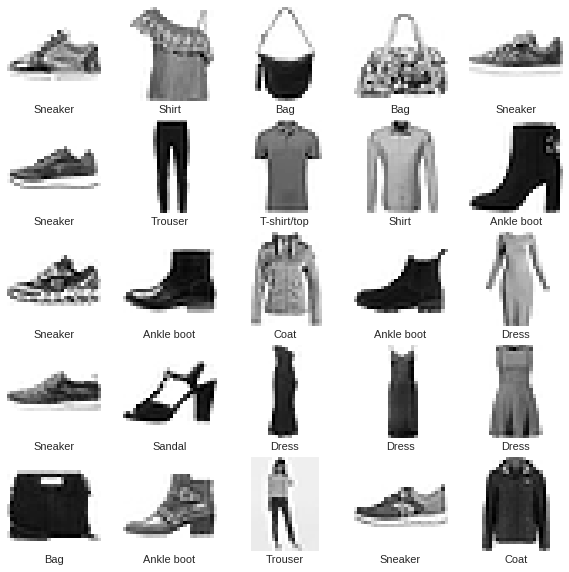

In [30]:
def get_fashion_MNIST_data():
    """ Download Fashion MNIST dataset. """

    # Step 1: Get the Data
    train_data, test_data = datasets.fashion_mnist.load_data()  # Download FMNIST

    # Step 2: Preprocess Dataset
    """ Centering and Normalization
        Perform centering by mean subtraction, and normalization by dividing with 
        the standard deviation of the training dataset.
    """
    train_data_mean = np.mean(train_data[0])
    train_data_stdev = np.std(train_data[0])
    train_data = ((train_data[0] - train_data_mean) /
                  train_data_stdev, train_data[1])
    test_data = ((test_data[0] - train_data_mean) /
                 train_data_stdev, test_data[1])

    return train_data, test_data


def print_data_info():
    """ Print Information on the Fashion MNIST dataset. """

    train_data, test_data = get_fashion_MNIST_data()

    # Split dataset into images and labels
    train_images, train_labels = train_data
    test_images, test_labels = test_data
    # Class names (needed only for illustration purposes)
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                   'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Display information about the dataset
    print("Training Data ::: Images Shape: {}, Labels Shape: {}".format(
        train_images.shape, train_labels.shape))
    print("Test Data ::: Images Shape: {}, Labels Shape: {}".format(
        test_images.shape, test_labels.shape))
    print("Random 25 Images from the Training Data:")
    plt.figure(figsize=(10, 10))
    for i in range(25):
        rand_image_idx = np.random.randint(0, train_labels.shape[0])
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')
        plt.imshow(train_images[rand_image_idx], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[rand_image_idx]])
    plt.show()
    
print_data_info()

# Building the model

Using Deepmind's Sonnet library we'll build two models, one a simple Multi-Layer Perceptron (MLP), another a Convolutional Network. We'll then setup the training apparatus such that switching between the two models would be a simple configuration parameter.

As an aside, [Keras](https://keras.io/) is another High-level API, which from TF v1.9 onward is tightly integrated into TF. Rapid prototyping is instrumental for any ML research project and both Keras and Sonnet are extremely useful in that regard. Admittedly, Keras is a much more mature project and has the official backing of the TF team. Moreover, there is a multitude of Keras tutorials and projects on the interweb, adding one more doesn't make any sense. On the other hand, Sonnet is rarely used outside of Deepmind, but is a must know for anyone following their research.

## Deepmind Sonnet
Sonnet is a TensorFlow library from Deepmind which abstract out the process of model building. The zen of sonnet is to encapsulate components of your model as python objects (modules) which can then be plugged into a TF graph as and when required, thus providing a seamless mechanism for code reuse. Such a design allows us to not bother about the internal configuration like variable reuse, weight sharing etc. For a detailed guide refer their official [documentation](https://deepmind.github.io/sonnet/). Also, their source code is well documented and worth reading, especially when stuck trying to implement something.

In our example we'll create two modules: `FMNISTMLPClassifier` and `FMNISTConvClassifier`. As the name suggests `FMNISTMLPClassifier` uses an MLP, and `FMNISTConvClassifier` uses a convolutional neural network. We'll then setup the training apparatus in TensorFlow and then plug-in the model we want to train.

In [0]:
# Step 3: Build the model

# Multi-Layer Perceptron
class FMNISTMLPClassifier(snt.AbstractModule):
    """ Model for Classifying FMNIST dataset based on a Multi-Layer Perceptron """

    def __init__(self, name='fmnist_mlp_classifier'):
        """ Initialize the MLP based classifier.

            We have only initialized the module name to keep things simple. In 
            practice we should make our models more configurable, like including 
            a parameter to choose the number of hidden layers in our MLP.
        """

        super().__init__(name=name)

    def _build(self, inputs):
        """ Build the model stack.

            Stacks the necessary modules/operations needed to build the model.

            Model Stack:            
            1. BatchFlatten: Flattens the image tensor into a 1-D tensor so that 
                each pixel of the image has a corresponding input neuron.
            2. MLP: A configurable MLP module that comes with Sonnet. We'll 
                configure it as a two layer MLP with 128 neurons in the hidden 
                layer and 10 neurons in the output layer.        
        """

        outputs = snt.BatchFlatten()(inputs)  # Input layer with 784 neurons
        outputs = snt.nets.MLP(  # MLP module from Sonnet
            output_sizes=[128, 10],
            name='fmnist_mlp'
        )(outputs)

        return outputs


# Convolutional Neural Network
class FMNISTConvClassifier(snt.AbstractModule):
    """ Model for Classifying FMNIST dataset based on a Multi-Layer Perceptron """

    def __init__(self, name='fmnist_conv_classifier'):
        """ Initialize the conv net based classifier.

            We have only initialized the module name to keep things simple. In 
            practice we should make our models more configurable, like including 
            a parameter to choose the number of convolutional layers in the Conv net.
        """

        super().__init__(name=name)

    def _build(self, inputs):
        """ Build the model stack.

            Stacks the necessary modules/operations needed to build the model.

            Model Stack:            
            1. expand_dims: Tensorflow op to expand dimensions of the input 
                data to match the shape required by the Conv net.
            2. ConvNet2D: A configurable 2D Convolutional Neural Network module 
                that comes with Sonnet. We'll configure it to have two 
                convolutional layers. For more details on conv nets refer the 
                CS231n stanford course notes (http://cs231n.github.io/convolutional-networks/)
            3. BatchFlatten: Flattens the output tensor from the conv net into 
                a 1-D tensor so that each pixel of the image has a corresponding 
                input neuron.
            4. MLP: the fully connected network module that comes with Sonnet 
                (essentially an MLP). We'll configure it as a two layer MLP with 
                64 neurons in the hidden layer and 10 neurons in the output layer.  
        """

        # Shape: (BATCH_SIZE, 28, 28, 1)
        inputs = tf.expand_dims(inputs, axis=-1)
        outputs = snt.nets.ConvNet2D(
            output_channels=[64, 32],  # Two Conv layers
            kernel_shapes=[5, 5],
            strides=[2, 2],
            paddings=[snt.SAME],
            # By default final layer activation is disabled.
            activate_final=True,
            name='convolutional_module'
        )(inputs)
        outputs = snt.BatchFlatten()(outputs)  # Input layer for FC network
        outputs = snt.nets.MLP(  # Fully Connected layer
            output_sizes=[64, 10],
            name='fully_connected_module'
        )(outputs)

        return outputs

## Putting Together the training apparatus.

The training apparatus contains the following components.

1. The Input Pipeline through which the data is fed to the model
2. An Optimization algorithm for performing Gradient Descent.
3. A Loss function that is to be optimized by the Optimizer.
4. The model that is being trained.

#### Input pipeline
In TensorFlow the preferred way to feed data to a model is using the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) module.  It allows us to apply transformations on input data in a simple and reusable manner. The `tf.data` module allows us to design input pipelines like aggregating data from multiple sources, adding complex data manipulation tasks in a pluggable manner etc. In this example we showcase its basic functionalities, the reader is encouraged to go through the official [guide](https://www.tensorflow.org/guide/datasets).

We want our input pipeline to have the following three properties:

1. Ability to switch between training and test datasets seamelessly, allowing us to perform evaluation after every [epoch](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9).
2. Shuffle the dataset to avoid learning unintended correlation from the ordering of data on disk.
3. Batch the dataset for Stochastic Gradient Descent.

In a single epoch the training loop would contain multiple mini-batch training passes covering the entire dataset, and then an accuracy evaluation over the test dataset.

#### Optimizer
The Adam (Adaptive Moment Estimation) Optimizer is a variant of Stochastic Gradient Descent. Among many other techniques, Adam uses adaptive learning rates for each parameter. This allows parameters that are associated with features that are uncommon to have aggressive learning rates and those with common features to have low learning rates. For a detailed exposition on different SGD optimizer read this wonderful [post](http://ruder.io/optimizing-gradient-descent/).

#### Loss Function
Evaluate the Cross Entropy Loss after performing softmax on the output from the model. More deatils [here](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

#### Model
The models we built using Sonnet. We'll setup the training such that we can swap the two model (MLP and ConvNet) based on a configuration parameter value.

In [0]:
def get_model(model_name='mlp'):
    """ Helper function to make model configurable """

    if model_name == 'mlp':
        return FMNISTMLPClassifier()
    if model_name == 'conv':
        return FMNISTConvClassifier()
    raise Exception('Invalid Model')


def train(model_name, batch_size=1000, epoch=5):
    """ Training the model """

    train_data, test_data = get_fashion_MNIST_data()

    train_images, train_labels = train_data
    test_images, test_labels = test_data

    """ Now that we're going to start building our DataFlow graph, its a good 
        practice to reset the graph before starting to add ops.
    """
    tf.reset_default_graph()

    """ Since the dataset is huge, directly creating the `tf.data.Dataset` object from 
        a tensor would result in a constant op getting added to the graph. Since constant 
        ops store data in-graph, the size of the graph blows us. To avoid this we need 
        to use a placeholder.
    """
    # Training dataset placeholders
    train_images_op = tf.placeholder(
        shape=train_images.shape, dtype=tf.float32, name='train_images_ph')
    train_labels_op = tf.placeholder(
        shape=train_labels.shape, dtype=tf.int64, name='train_labels_ph')

    # Test dataset placeholders
    test_images_op = tf.placeholder(
        shape=test_images.shape, dtype=tf.float32, name='test_images_ph')
    test_labels_op = tf.placeholder(
        shape=test_labels.shape, dtype=tf.int64, name='test_labels_ph')

    # placeholder for the batch size, we need it to change the
    # batch size when we switch between datasets.
    batch_size_op = tf.placeholder(dtype=tf.int64)

    """ Create the input pipeline from the training and test data placeholders.
        1. Get data from data placeholder
        2. Shuffle the data
        3. Batch it with size batch_size_op
    """
    train_dataset_op = tf.data.Dataset.from_tensor_slices(
        (train_images_op, train_labels_op))
    train_dataset_op = train_dataset_op.shuffle(buffer_size=10000)
    train_dataset_op = train_dataset_op.batch(batch_size_op)

    test_dataset_op = tf.data.Dataset.from_tensor_slices(
        (test_images_op, test_labels_op))
    test_dataset_op = test_dataset_op.shuffle(buffer_size=10000)
    test_dataset_op = test_dataset_op.batch(batch_size_op)

    """ Create a reinitializable iterator. This type of iterator can be 
        initialized with any dataset that contains records with similar type 
        and shape. Since the records in the training and test dataset share 
        similar type and shape we can use this iterator to swap them.
    """
    iterator_op = tf.data.Iterator.from_structure(
        train_dataset_op.output_types,
        train_dataset_op.output_shapes)
    next_batch_images_op, next_batch_labels_op = iterator_op.get_next()

    training_init_op = iterator_op.make_initializer(train_dataset_op)
    testing_init_op = iterator_op.make_initializer(test_dataset_op)

    # Obtain the desired model to be training from a configuration parameter.
    model = get_model(model_name)

    # Step 4: Setup the training apparatus
    prediction_op = model(next_batch_images_op)  # Forward pass Op
    loss_op = tf.losses.sparse_softmax_cross_entropy(
        next_batch_labels_op, prediction_op)  # Loss Op
    optimizer = tf.train.AdamOptimizer()  # Optimizer Op
    sgd_step = optimizer.minimize(loss_op)  # Gradient Descent step Op.

    """ Op to evaluate training and test accuracy every epochs. 
        `tf.metrics.accuracy` returns two ops, `acc_op` which simple perform a 
        calculation to give the current accuracy, and `acc_update_op` which 
        actually perform the evaluation and keeps tracks of the counts needed 
        to evaluate accuracy.
    """
    acc_op, acc_update_op = tf.metrics.accuracy(
        labels=next_batch_labels_op,
        predictions=tf.argmax(prediction_op, 1),
        name='accuracy_metric'
    )

    """ Since we want to evaluate both test and training accuracy we need to 
        make sure that the count variables in the accuracy op is reset after 
        each evaluation. In order to do that we need to create an initializer 
        just for the variables associated with the accuracy op. When this 
        initializer is called after (or before) every evaluation we can ensure 
        that the count variables are reset.
    """
    # Get initializer for accuracy vars to reset them after each epoch.
    accuracy_running_vars = tf.get_collection(
        tf.GraphKeys.LOCAL_VARIABLES, scope="accuracy_metric")
    accuracy_vars_initializer = tf.variables_initializer(
        var_list=accuracy_running_vars)

    # Pre-defined Feed dicts to sent data to placeholders.
    train_feed_dict = {train_images_op: train_images,
                       train_labels_op: train_labels, batch_size_op: batch_size}
    train_eval_feed_dict = {train_images_op: train_images,
                            train_labels_op: train_labels,
                            batch_size_op: len(train_labels)}
    test_feed_dict = {test_images_op: test_images,
                      test_labels_op: test_labels,
                      batch_size_op: len(test_labels)}

    # Step 5: Train
    with tf.Session() as sess:
        # Initialize local and global variables
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())

        # Epochs
        for idx in range(epoch):
            start = time.time()  # Taking time to track training duration for epoch

            # Initialize accuracy count variable for evaluating training accuracy
            sess.run(accuracy_vars_initializer)

            # Initalize the datset iterator with the training dataset.
            sess.run(training_init_op, feed_dict=train_feed_dict)

            # Loop until the SGD is performed over the entire dataset.
            while True:
                try:
                    # After an SGD step perform training accuracy evaluation for the current batch
                    sess.run([sgd_step, acc_update_op],
                             feed_dict=train_feed_dict)
                except tf.errors.OutOfRangeError:  # No more data in the input pipeline
                    break
            # Calculate training time for epoch.
            train_time = time.time()-start

            print("Epoch {:d} ::: Training Time: {:.2f}s,".format(
                idx+1, train_time), end=' ')

            # Evaluate the training loss with the current model
            sess.run(training_init_op, feed_dict=train_eval_feed_dict)
            print("Training Loss: {:.5f},".format(
                sess.run(loss_op, feed_dict=train_eval_feed_dict)), end=' ')

            print("Training Accuracy: {:.5f},".format(
                sess.run(acc_op)), end=' ')

            # Initialize accuracy count variable for evaluating test accuracy
            sess.run(accuracy_vars_initializer)

            # Initialize the dataset iterator with the test dataset.
            sess.run(testing_init_op, feed_dict=test_feed_dict)

            # Perform accuracy evaluation for the entire test dataset in one go.
            sess.run(acc_update_op, feed_dict=test_feed_dict)
            print("Test Accuracy: {:.5f}".format(sess.run(acc_op)))

In [33]:
train('conv', batch_size=200, epoch=10)

Epoch 1 ::: Training Time: 26.89s, Training Loss: 0.35364, Training Accuracy: 0.83080, Test Accuracy: 0.85760
Epoch 2 ::: Training Time: 26.74s, Training Loss: 0.26473, Training Accuracy: 0.88595, Test Accuracy: 0.88670
Epoch 3 ::: Training Time: 26.15s, Training Loss: 0.23713, Training Accuracy: 0.90160, Test Accuracy: 0.89110
Epoch 4 ::: Training Time: 25.82s, Training Loss: 0.20253, Training Accuracy: 0.91448, Test Accuracy: 0.90310
Epoch 5 ::: Training Time: 26.45s, Training Loss: 0.17938, Training Accuracy: 0.92133, Test Accuracy: 0.90400
Epoch 6 ::: Training Time: 26.39s, Training Loss: 0.17493, Training Accuracy: 0.92885, Test Accuracy: 0.90230
Epoch 7 ::: Training Time: 26.70s, Training Loss: 0.14085, Training Accuracy: 0.93642, Test Accuracy: 0.90810
Epoch 8 ::: Training Time: 26.26s, Training Loss: 0.13515, Training Accuracy: 0.94180, Test Accuracy: 0.90090
Epoch 9 ::: Training Time: 25.98s, Training Loss: 0.12340, Training Accuracy: 0.94870, Test Accuracy: 0.90550
Epoch 10 :

## References

1.  [LeCun, Yann A., et al. "Efficient backprop."](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)
2. [Deepmind Sonnet](https://deepmind.github.io/sonnet/)
3. [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)
4. [Basic Classification from TF Guide](https://www.tensorflow.org/tutorials/keras/basic_classification)
5. [CS231n stanford course notes](http://cs231n.github.io/convolutional-networks/)
6. [ML CheatSheet Loss Functions](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)
7. [TF Metrics](https://steemit.com/machine-learning/@ronny.rest/avoiding-headaches-with-tf-metrics)
